# "Urban Mobility and Social Equity: Mapping Transit Access in Toulouse"

### Big Data 3 Project by Elie LEFEBVRE MAG-1

First of all, my project explores urban mobility, focusing on how transportation options like `subways` and `city bikes` serve rich and poor neighborhoods differently. I always though that suburbs where sometimes almost force to use the car for a daily use because of the poor mobilities options proposed and not because of lack of ecological awareness.
Starting with this premise, I discovered the `JCDecaux Developer API` and the `Data Toulouse-Metropole API`, which provide live data from city bikes in 27 cities worldwide and data from Toulouse subways.
I decided to use these APIs to fuel my project, focusing on Toulouse, the city where I'm from.  Initially, I considered using libraries like `Shapefile` or `GeoPandas` to plot maps in Python but because I wanted to integrate a square meter price map of Toulouse, I couldn't use these librairies, obviously the map was not well-known. In fact,the map of sqm2 house prices was almost only available on a jpeg extension. Fortunately, I came across a project on `TowardsDataScience.com` that demonstrated how to plot GPS coordinates on a JPEG image—a method that perfectly suited my needs. All I had to do was find a real estate website map of Toulouse showing neighborhood prices, and then input my GPS coordinates. Bingo!
However, there was a catch: the original function from the project was designed to plot a hiking trail on a JPEG using GPS coordinates. I needed to adapt this function to plot only points without linking them. So I post a comment on the project.


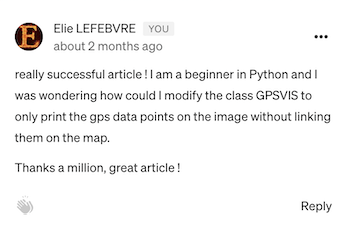 

Two months later, I guess we'll never know... So I ask Gpt 4 how could I adapt the code and he advises me to modify on the loop for in the create image function, inside the GPSvisClass, replace the function "draw.line" by "draw.ellipse".
I guess I could have found it myself... Anyways, after adapting the function, it works!
I am now able to import data from the API's, load the JPEG map of Toulouse, clean the data to make it readable for my function, and finally, plot the map with the GPS coordinates. I want to plot few maps, showing the effect of the new ligne C of the subway on the equality of ways of mobilites between neighborhoods.

# IMPORT GPS COORDINATES OF TOULOUSE CITYBIKES FROM JCDECAUX API


In [2]:
import pandas as pd
import requests

API_KEY = "cfc66f13c888c69fcfc454fca033077d59036ed6"
ville = "Toulouse"
response = requests.get(f'https://api.jcdecaux.com/vls/v1/stations?apiKey={API_KEY}&contract={ville}')
if response.status_code == 200:
    data = response.json()
    df = pd.DataFrame(data)
    df['Latitude'] = df['position'].apply(lambda pos: pos['lat'])
    df['Longitude'] = df['position'].apply(lambda pos: pos['lng'])
    df[['Latitude', 'Longitude']].to_csv("Desktop/Big_data_3_ELIE_LEFEBVRE/cleaned_gps_citybikes.csv", index=False, header=False)
    print("Data saved to cleaned_gps_citybikes.csv successfully.")
else:
    print(f"Problem with the data: {response.status_code}")

OSError: Cannot save file into a non-existent directory: 'Desktop/Big_data_3_ELIE_LEFEBVRE'

I had to clean the data properly to have only the latitude and longitude separated by a comma because the GPS VIS that we will use 
shortly is not really flexible and robustness so we need to input clean data only.

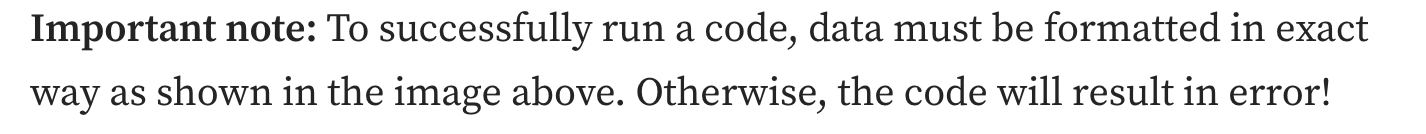

# IMPORT GPS COORDINATES OF TOULOUSE SUBWAYS STATIONS FROM TOULOUSE METROPOLE API

In [ ]:
import pandas as pd
import requests

url = 'https://data.toulouse-metropole.fr/api/explore/v2.1/catalog/datasets/stations-de-metro/records?limit=100'
response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    coordinates = [
        (record['geo_point_2d']['lat'], record['geo_point_2d']['lon'])
        for record in data['results']
        if 'geo_point_2d' in record and record.get('ligne') in ['A', 'B']  ]

    df = pd.DataFrame(coordinates, columns=['Latitude', 'Longitude'])
    df.to_csv("Desktop/Big_data_3_ELIE_LEFEBVRE/cleaned_gps_subways_lines_A_B.csv", index=False, header=False)
    print("Data saved to cleaned_gps_subways_lines_A_B.csv successfully.")
else:
    print(f"Problem with data: {response.status_code}")

 I adapted a bit the previous code(JCDECAUX API data extraction) because of new structure of the data in the Toulouse metropole API but it follows the same goal: `clean the GPS Coordinates data`.
 I filtrated also only the station of the current lines A and B because there was also GPS coordinates of few stations of lines C. Few and not all of them, this is why I will import an other database of GPS coordinates of stations of line C and not use this database .

# IMPORT GPS COORDINATES OF TOULOUSE SUBWAYS STATIONS LINE C FROM SCRAPING WIKIPEDIA

To find the GPS coordinates of stations C, I don't know why it was not available fully on data.toulouse-metrople api, only 6 of them where available whereas we already know that they will be more than 20 stations on the line. I only found clear and complete data on wikipedia's page: Ligne C du métro de Toulouse. But i had to scrape the wikipedia article to extract the data I needed.
I found this extremely helpfull website explaining what I needed:

https://github.com/rocheio/wiki-table-scrape
https://stackoverflow.com/questions/48016979/web-scraping-tables-using-python
But there was a other catch afters hours trying to inspect the wikipedia page to understand what was the id of the table I was wondering to import or the class, anything that could make me indentify it, I finally understand that even tho it was looking like a table on the page it was not a table but only content text plot with colours! This is why I couldn't extract it with my scraping method for table found on these two previous website. Finally, I could extract the content_text_element from the wiki page and the using a new very usefull library dms2dec I could extract the gps coordinates and convert them to the same format as before.

https://stackoverflow.com/questions/33997361/how-to-convert-degree-minute-second-to-degree-decimal

In [ ]:
import requests
from bs4 import BeautifulSoup
import re
from dms2dec.dms_convert import dms2dec
import pandas as pd

url = "https://fr.wikipedia.org/wiki/Mod%C3%A8le:M%C3%A9tro_de_Toulouse/ligne_C"
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
content_text_element = soup.find(id='mw-content-text')
content_text = content_text_element.get_text(separator=' ', strip=True)
pattern = re.compile(r'\d{1,3}°\s*\d{1,2}′\s*\d{1,2}″\s*[N|S],\s*\d{1,3}°\s*\d{1,2}′\s*\d{1,2}″\s*[E|W]')
gps_coordinates = pattern.findall(content_text)
data = []
for coords in gps_coordinates:
    lat_dms, lon_dms = coords.split(", ")
    lat_dec = dms2dec(lat_dms)
    lon_dec = dms2dec(lon_dms)
    data.append({'Latitude': lat_dec, 'Longitude': lon_dec})
df = pd.DataFrame(data)
df.to_csv('Desktop/Big_data_3_ELIE_LEFEBVRE/ligne_c_gps_coordinates.csv', index=False, header=False)




In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

class GPSVis(object):
    """
        Class for GPS data visualization using pre-downloaded OSM map in image format.
    """
    def __init__(self, data_path, map_path, points):
        """
        :param data_path: Path to file containing GPS records.
        :param map_path: Path to pre-downloaded OSM map in image format.
        :param points: Upper-left, and lower-right GPS points of the map (lat1, lon1, lat2, lon2).
        """
        self.data_path = data_path
        self.points = points
        self.map_path = map_path

        self.result_image = Image
        self.x_ticks = []
        self.y_ticks = []

    def plot_map(self, output='save', save_as='resultMap.png'):
        """
        Method for plotting the map. You can choose to save it in file or to plot it.
        :param output: Type 'plot' to show the map or 'save' to save it.
        :param save_as: Name and type of the resulting image.
        :return:
        """
        self.get_ticks()
        fig, axis1 = plt.subplots(figsize=(10, 10))
        axis1.imshow(self.result_image)
        axis1.set_xlabel('Longitude')
        axis1.set_ylabel('Latitude')
        axis1.set_xticklabels(self.x_ticks)
        axis1.set_yticklabels(self.y_ticks)
        axis1.grid()
        if output == 'save':
            plt.savefig(save_as)
        else:
            plt.show()

    def create_image(self, color, width=2):
        """
        Create the image that contains the original map and the GPS records.
        :param color: Color of the GPS records.
        :param width: Width of the drawn GPS records.
        :return:
        """
        data = pd.read_csv(self.data_path, names=['LATITUDE', 'LONGITUDE'], sep=',')

        self.result_image = Image.open(self.map_path, 'r')
        draw = ImageDraw.Draw(self.result_image)
        gps_data = tuple(zip(data['LATITUDE'].values, data['LONGITUDE'].values))
        for d in gps_data:
            x1, y1 = self.scale_to_img(d, (self.result_image.size[0], self.result_image.size[1]))
            draw.ellipse((x1-width, y1-width, x1+width, y1+width), fill=color)

    def scale_to_img(self, lat_lon, h_w):
        """
        Conversion from latitude and longitude to the image pixels.
        It is used for drawing the GPS records on the map image.
        :param lat_lon: GPS record to draw (lat1, lon1).
        :param h_w: Size of the map image (w, h).
        :return: Tuple containing x and y coordinates to draw on map image.
        """
        old = (self.points[2], self.points[0])
        new = (0, h_w[1])
        y = ((lat_lon[0] - old[0]) * (new[1] - new[0]) / (old[1] - old[0])) + new[0]
        old = (self.points[1], self.points[3])
        new = (0, h_w[0])
        x = ((lat_lon[1] - old[0]) * (new[1] - new[0]) / (old[1] - old[0])) + new[0]
        return int(x), h_w[1] - int(y)

    def get_ticks(self):
        """
        Generates custom ticks based on the GPS coordinates of the map for the matplotlib output.
        :return:
        """
        self.x_ticks = map(
            lambda x: round(x, 4),
            np.linspace(self.points[1], self.points[3], num=7))
        y_ticks = map(
            lambda x: round(x, 4),
            np.linspace(self.points[2], self.points[0], num=8))
        self.y_ticks = sorted(y_ticks, reverse=True)




Here is the adapted class of GPSVIS to plot points as explained in the introduction, from Leo Tisljaric.
It's available on github on this link (1)or explained with details on these websites (2).

(1): https://towardsdatascience.com/simple-gps-data-visualization-using-python-and-open-street-maps-50f992e9b676

(2): https://github.com/tisljaricleo/GPS-visualization-Python

Unfortunatelly, GPS Coordinates of new citybikes stations coming in the next are not already available because still on discussion about precise localisation. 

I can now plot few differents maps using the data I cleaned.
(the points asked on the function are the bottom right and the upper left to have the landmark between pixels of the jpeg and gps data points)


In [ ]:
vis = GPSVis(data_path='Desktop/Big_data_3_ELIE_LEFEBVRE/leaned_gps_subways_lines_A_B.csv',
             map_path='Desktop/Big_data_3_ELIE_LEFEBVRE/Toulouse prix m2.png',  
             points=(43.6816,1.3420, 43.5264,1.5611)) 

vis.create_image(color=(0, 0, 0), width=5) 
vis.plot_map(output='save')

print()

In [ ]:
vis = GPSVis(data_path='Desktop/Big_data_3_ELIE_LEFEBVRE/ligne_c_gps_coordinates.csv',
             map_path='Desktop/Big_data_3_ELIE_LEFEBVRE/Toulouse prix m2.png',  
             points=(43.6816,1.3420, 43.5264,1.5611)) 

vis.create_image(color=(0, 0, 0), width=5) 
vis.plot_map(output='save')

print()


In [ ]:
vis = GPSVis(data_path='Desktop/Big_data_3_ELIE_LEFEBVRE/cleaned_gps_citybikes.csv',
             map_path='Desktop/Big_data_3_ELIE_LEFEBVRE/Toulouse prix m2.png',  
             points=(43.6816,1.3420, 43.5264,1.5611)) 

vis.create_image(color=(0, 0, 0), width=5) 
vis.plot_map(output='save')

print()

how to add two csv together:
https://techexpert.tips/fr/python-fr/python-combinaison-de-fichiers-csv/

In [ ]:
vis = GPSVis(data_path='Desktop/Big_data_3_ELIE_LEFEBVRE/Now.csv',
             map_path='Desktop/Big_data_3_ELIE_LEFEBVRE/Toulouse prix m2.png',  
             points=(43.6816,1.3420, 43.5264,1.5611)) 

vis.create_image(color=(0, 0, 0), width=5) 
vis.plot_map(output='save')

print()


## Heat Map with City bikes stations and the two currents lines

In [ ]:
vis = GPSVis(data_path='Desktop/Big_data_3_ELIE_LEFEBVRE/FULL_GPS.csv',
             map_path='Desktop/Big_data_3_ELIE_LEFEBVRE/Toulouse prix m2.png',  
             points=(43.6816,1.3420, 43.5264,1.5611)) 

vis.create_image(color=(0, 0, 0), width=5) 
vis.plot_map(output='save')

print()

## Heat Map with City bikes stations, two currents lines and the futur line

Now I can clearly see on the sq-m2 heatmap that the new subway is going to go to suburbs. Soon I will add the citybikes GPS localisation to see the full effect of these urban policies on the social equity to ecological transportation.  